# Generate Twisted Bilayer Structures

Maintainer: Zekun Lou

This notebook provides a step-by-step guide to generating twisted bilayer structures, with a focus on calculating commensurate twist angles, implementing the necessary code, and visualizing the results.

**Graphene** is used as the illustrative example throughout.
Detailed explanation can be found in [the appendix of this paper](https://doi.org/10.1103/PhysRevB.86.155449).

The most important step for generating a twisted bilayer structure is calculating the **commensurate twist angle**, which ensures proper periodicity in the resulting lattice.
Corresponding lattice transformation matrix can also be determined from the commensurate angle calculation.

The commensurate angle $\theta$ is defined such that, in a hexagonal lattice, a pair of lattice points located at $(m, n)$ and $(n, m)$ in the lattice vector basis, and all their $C_{n}$ (depending on the lattice symmetry) symmetric pairs, will coincide after rotation by $\theta(m, n)$, forming a periodic structure.

A visual explanation of the commensurate angle in hexagon lattice is provided below: one of the two layers rotated clockwise by $\theta/2$, while the other is rotated counterclockwise by $\theta/2$.
This results in the overlapping of lattice pair $(m, n)$ and $(n, m)$ (and all their $C_6$ symmetric pairs) after rotation, forming a commensurate structure with manageable periodicity in real space.

For simplicity, parameter $r=n-m$ is introduced, making twist angle parameterized as $\theta(m,r)$.
To reach small twist angles, one can take $r=1$ and increase $m$.

![](./twist_angle_explained.png)

In [1]:
""" load minimal dependencies """

import numpy
import matplotlib.pyplot as plt
from ase.atoms import Atoms
from ase.build import make_supercell
from ase.visualize import view

In [2]:
def get_twist_property(m: int, r: int):
    """
    Equations from the appendix of:
    J. M. B. Lopes dos Santos, N. M. R. Peres, and A. H. Castro Neto, Continuum model of the twisted graphene bilayer, Phys. Rev. B 86, 155449 (2012).
    """
    # check coprime
    if numpy.gcd(m, r) != 1:
        raise ValueError(f"m={m} and r={r} are not coprime")
    numerator = 3 * m**2 + 3 * m * r + r**2 / 2
    denominator = 3 * m**2 + 3 * m * r + r**2
    twist_angle = numpy.arccos(numerator / denominator)
    if numpy.gcd(r, 3) == 1:
        transform_matrix_2d = numpy.array(
            [
                [m, m + r],
                [-m - r, 2 * m + r],
            ]
        )
    elif numpy.gcd(r, 3) == 3:
        transform_matrix_2d = numpy.array(
            [
                [m + r / 3, r / 3],
                [-r / 3, m + 2 * r / 3],
            ]
        )
    else:
        raise ValueError(f"gcd(r,3) should be 1 or 3, but got {numpy.gcd(r,3)}")
    transform_matrix = numpy.eye(3, dtype=int)  # identity 3x3 matrix
    transform_matrix[:2, :2] = transform_matrix_2d
    return {
        "twist_angle": twist_angle,  # fix one lattice, rotate the other
        "transform_matrix": transform_matrix,  # the superlattice follows this transformation
    }

print("The largest twist angle (m=1, r=1) in degrees:", numpy.degrees(get_twist_property(1,1)["twist_angle"]))
print("The medium-size twist angle (m=3, r=1) in degrees:", numpy.degrees(get_twist_property(3,1)["twist_angle"]))
print("TBG magic angle (m=31, r=1) in degrees:", numpy.degrees(get_twist_property(31,1)["twist_angle"]))

The largest twist angle (m=1, r=1) in degrees: 21.78678929826181
The medium-size twist angle (m=3, r=1) in degrees: 9.430007907896421
TBG magic angle (m=31, r=1) in degrees: 1.0501208797943464


We can visualize what does the corresponding supercell transformation matrix do to primitive cells.

In [3]:
def visualize_2d_atoms(atoms:Atoms, plt_kwargs:dict=None, ax:plt.Axes=None,):
    """ visualize a 2D atomic structure with cell """
    if ax is None:
        ax = plt.gca()
    _plt_kwargs = {"s": 100,}
    if plt_kwargs is not None:
        _plt_kwargs.update(plt_kwargs)
    # plot atoms
    ax.scatter(
        atoms.positions[:,0], atoms.positions[:,1],
        alpha=numpy.array(atoms.positions[:,2])/atoms.cell[2,2],
        **_plt_kwargs
    )
    # plot cell
    cell_vertices_loop = numpy.array([
        [0.,0.,],
        atoms.cell[0,:2],
        atoms.cell[0,:2] + atoms.cell[1,:2],
        atoms.cell[1,:2],
        [0.,0.,],
    ])
    ax.plot(cell_vertices_loop[:,0], cell_vertices_loop[:,1], color='black', linestyle='--',)
    ax.set_aspect('equal')
    return ax


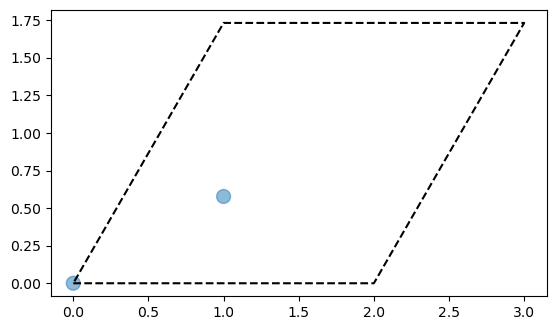

In [4]:
""" create primitive cell of graphene """

primitive_cell_a = 2.0  # primitive cell lattice constant in Angstrom
primitive_cell_z = 10.0
atoms_primitive = Atoms(
    symbols="CC",
    positions=numpy.array([
        [0, 0, 0.5 * primitive_cell_z],
        [0.5 * primitive_cell_a, 3**0.5 / 6 * primitive_cell_a, 0.5 * primitive_cell_z],
    ]),
    cell=[
        [primitive_cell_a, 0, 0],
        [0.5 * primitive_cell_a, 3**0.5 / 2 * primitive_cell_a, 0],
        [0, 0, primitive_cell_z],
    ],
    pbc=True,
)
visualize_2d_atoms(atoms_primitive);

{'twist_angle': 0.16458468648189473, 'transform_matrix': array([[ 3,  4,  0],
       [-4,  7,  0],
       [ 0,  0,  1]])}


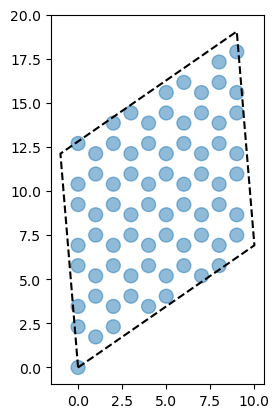

In [5]:
""" apply transformation matrix to primitive cell """

twist_property = get_twist_property(m=3, r=1)
print(twist_property)
atoms_supercell_0 = make_supercell(
    atoms_primitive,
    twist_property["transform_matrix"],
)
visualize_2d_atoms(atoms_supercell_0);
view(atoms_supercell_0, viewer='x3d')


The transformation matrix doesn't change atomic positions, but changes the lattice vectors of the primitive cell.

In the same way, we generate the other layer's supercell, which should rotate in the opposite direction, and is equivalently a in-matrix inverse of the transformation matrix.

{'twist_angle': 0.16458468648189473, 'transform_matrix': array([[ 3,  4,  0],
       [-4,  7,  0],
       [ 0,  0,  1]]), 'transform_matrix_1': array([[ 7., -4.,  0.],
       [ 4.,  3.,  0.],
       [ 0.,  0.,  1.]])}


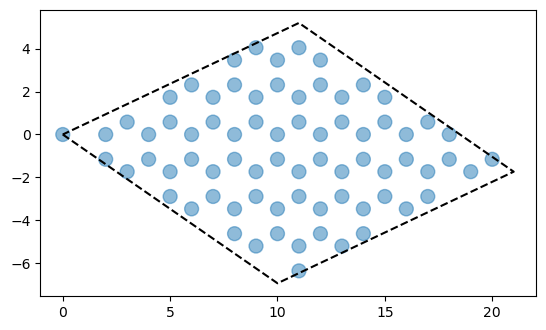

In [6]:
twist_property['transform_matrix_1'] = numpy.eye(3)
twist_property['transform_matrix_1'][:2, :2] = twist_property["transform_matrix"][:2,:2][::-1, ::-1]
print(twist_property)
atoms_supercell_1 = make_supercell(
    atoms_primitive,
    twist_property["transform_matrix_1"],
)
visualize_2d_atoms(atoms_supercell_1);
view(atoms_supercell_1, viewer='x3d')

To stack the two layers together, we need to align their cells first (align the first lattice vector by x-axis), and then concatenate the two atomic structures.

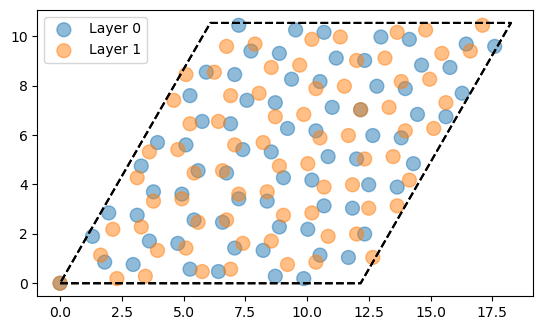

In [7]:
# calculate the angle between the first cell vector and the x axis
atoms_supercell_0_rotate_angel = -numpy.degrees(numpy.arctan(atoms_supercell_0.cell[0,1] / atoms_supercell_0.cell[0,0]))
atoms_supercell_0_aligned = atoms_supercell_0.copy()
atoms_supercell_0_aligned.rotate(atoms_supercell_0_rotate_angel, v='z', rotate_cell=True)

# same procedure for the other layer
atoms_supercell_1_rotate_angel = -numpy.degrees(numpy.arctan(atoms_supercell_1.cell[0,1] / atoms_supercell_1.cell[0,0]))
atoms_supercell_1_aligned = atoms_supercell_1.copy()
atoms_supercell_1_aligned.rotate(atoms_supercell_1_rotate_angel, v='z', rotate_cell=True)

ax = visualize_2d_atoms(atoms_supercell_0_aligned, {"color": "C0", "label": "Layer 0"})
visualize_2d_atoms(atoms_supercell_1_aligned, {"color": "C1", "label": "Layer 1"}, ax)
ax.legend()

Then we stack the two layers together, and visualize the final twisted bilayer structure.

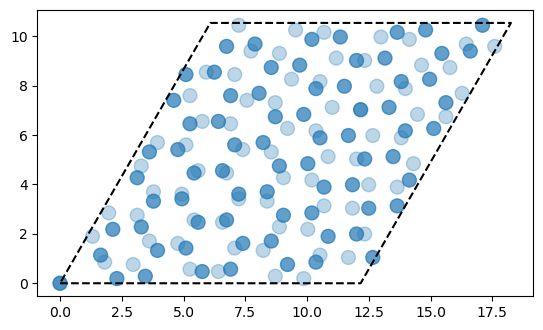

In [8]:
atoms_supercell_0_aligned.translate([0, 0, -2])  # interlayer distance
atoms_supercell_1_aligned.translate([0, 0, +2])  # interlayer distance
atoms_twist_bilayer = atoms_supercell_0_aligned + atoms_supercell_1_aligned
visualize_2d_atoms(atoms_twist_bilayer)
view(atoms_twist_bilayer, viewer='x3d')

We can generate magic angle TBG using the following code:

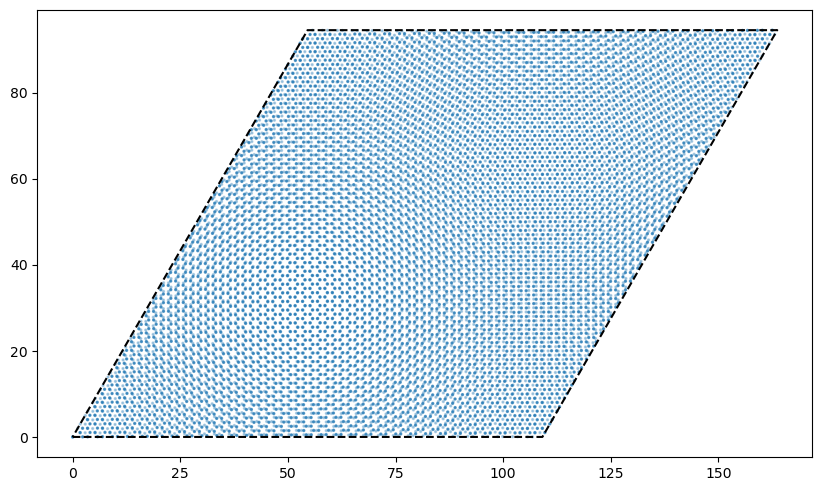

In [9]:
def generate_twisted_bilayers(atoms:Atoms, m:int, r:int, z:float, wrap:bool=True):
    """ generate twisted bilayer structure from a given monolayer structure """
    twist_property = get_twist_property(m=m, r=r)
    # layer 0
    atoms_layer_0 = make_supercell(
        atoms,
        twist_property["transform_matrix"],
    )
    rotate_angel_0 = -numpy.degrees(numpy.arctan(atoms_layer_0.cell[0,1] / atoms_layer_0.cell[0,0]))
    atoms_layer_0.rotate(rotate_angel_0, v='z', rotate_cell=True)
    atoms_layer_0.translate([0, 0, -z/2])
    # layer 1
    transform_matrix_1 = numpy.eye(3)
    transform_matrix_1[:2, :2] = twist_property["transform_matrix"][:2,:2][::-1, ::-1]
    atoms_layer_1 = make_supercell(
        atoms,
        transform_matrix_1,
    )
    rotate_angel_1 = -numpy.degrees(numpy.arctan(atoms_layer_1.cell[0,1] / atoms_layer_1.cell[0,0]))
    atoms_layer_1.rotate(rotate_angel_1, v='z', rotate_cell=True)
    atoms_layer_1.translate([0, 0, +z/2])
    # combine layers
    atoms_bilayer = atoms_layer_0 + atoms_layer_1
    if wrap:
        atoms_bilayer.wrap()
    return atoms_bilayer

atoms_MATBG = generate_twisted_bilayers(atoms_primitive, m=31, r=1, z=4)
fig, ax = plt.subplots(1,1, figsize=(10,6))
visualize_2d_atoms(atoms_MATBG, {"s": 2,}, ax=ax);